### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 
    

#### Tasks

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

file = '../../solutions/galaxyquasar.csv'

raw_data = pd.DataFrame(pd.read_csv(file))
raw_data.head()

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631


- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

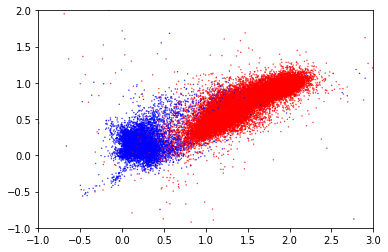

In [5]:
mycols = ['u - g', 'g - r', 'r - i', 'i - z', 'label', 'z', 'zerr']
labels = np.where(raw_data['class']=='QSO', 1, 0)

data = pd.DataFrame(columns = mycols)
data['u - g'] = raw_data['u']-raw_data['g']
data['g - r'] = raw_data['g']-raw_data['r']
data['r - i'] = raw_data['r']-raw_data['i']
data['i - z'] = raw_data['i']-raw_data['z']
data['label'] = labels
data['z'] = raw_data['z1']
data['zerr'] = raw_data['zerr']

rows, cols = np.shape(raw_data)
split = int(rows*0.6)
train_data = data.iloc[:split,:]
test_data = data.iloc[split:, :]

colors = np.where(data['label'] == 1, 'b', 'r')
plt.scatter(data['u - g'], data['g - r'], s=0.15, c=colors)

xlims = [-1,3]
ylims = [-1,2]
_=plt.ylim(ylims)
_=plt.xlim(xlims)

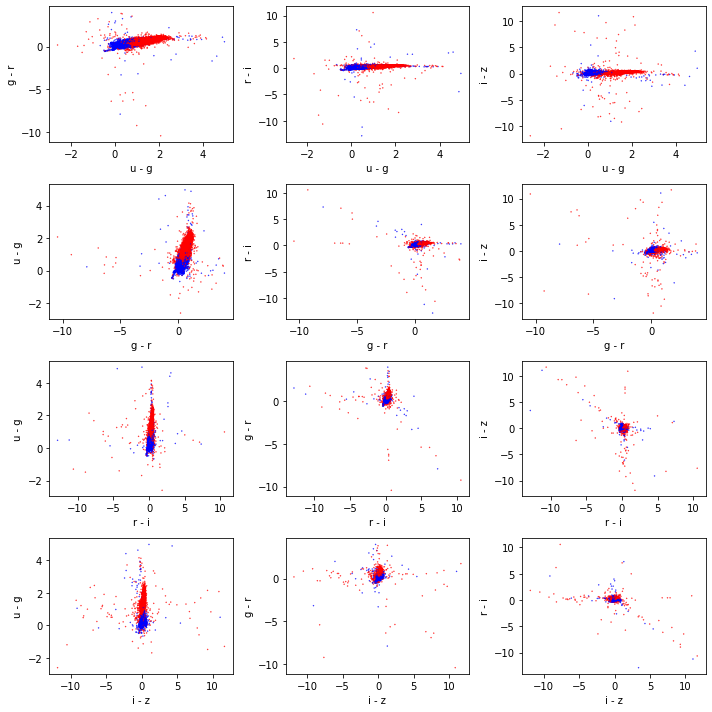

In [24]:
fig, axs = plt.subplots(4,3)
ax = axs.ravel()
k = 0
for i in range(4):
    for j in range(4):
        if i != j:
            ax[k].scatter(data.iloc[:,i], data.iloc[:,j], c=colors, s=0.15)
            ax[k].set_xlabel(mycols[i])
            ax[k].set_ylabel(mycols[j])
            k+=1
            
plt.rcParams["figure.figsize"] = [10,10]
fig.tight_layout()

In [13]:
"""
import corner

dataplot = np.vstack(data.iloc[:,0:4].to_numpy())
figure = corner.corner(dataplot, labels=mycols[:4])
"""

'\nimport corner\n\ndataplot = np.vstack(data.iloc[:,0:4].to_numpy())\nfigure = corner.corner(dataplot, labels=mycols[:4])\n'

- Classify the dataset against the target label.

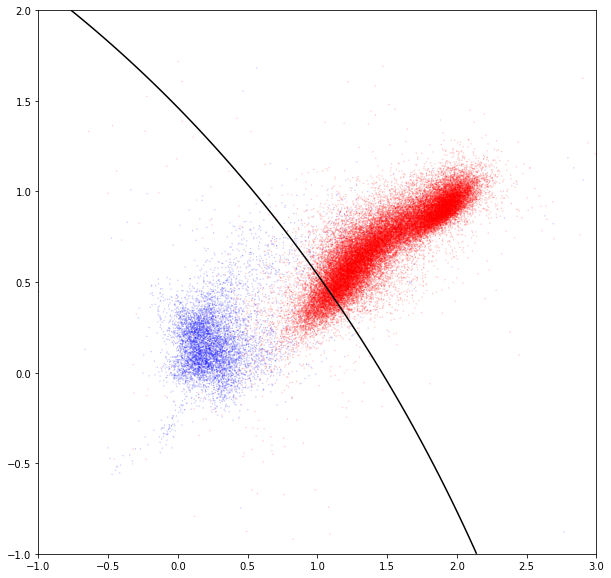

In [27]:
from sklearn.naive_bayes import GaussianNB

X = data['u - g'].to_numpy().reshape(-1,1)
y = data['label']

gnb = GaussianNB()
gnb.fit(X,y)

y_pred = gnb.predict(X)

xx, yy = np.meshgrid(np.linspace(*xlims,100),
                     np.linspace(*ylims,100))

Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

plt.scatter(data['u - g'], data['g - r'], s=0.01, c=colors)#, cmap=plt.cm.binary, zorder=2)
_=plt.xlim(xlims)
_=plt.ylim(ylims)
plt.contour(xx, yy, Z, [0.5], colors='k')

- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.

In [44]:
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

datasets = np.empty((4,4), dtype=tuple)
for i in range(4):
    for j in range(4):
        datasets[i][j] = ( data.iloc[:,i].to_numpy(), data.iloc[:,j].to_numpy() )
print(datasets.shape)

"""

h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Gaussian Process",
    "Naive Bayes"
]

classifiers = [
    KNeighborsClassifier(5),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GaussianNB()
]

### FIX THIS

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

"""

(4, 4)


'\n\nh = 0.02  # step size in the mesh\n\nnames = [\n    "Nearest Neighbors",\n    "Gaussian Process",\n    "Naive Bayes"\n]\n\nclassifiers = [\n    KNeighborsClassifier(5),\n    GaussianProcessClassifier(1.0 * RBF(1.0)),\n    GaussianNB()\n]\n\n### FIX THIS\n\ni = 1\n# iterate over datasets\nfor ds_cnt, ds in enumerate(datasets):\n    # preprocess dataset, split into training and test part\n    X, y = ds\n    X = StandardScaler().fit_transform(X)\n    X_train, X_test, y_train, y_test = train_test_split(\n        X, y, test_size=0.4, random_state=42\n    )\n\n    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5\n    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))\n\n    # just plot the dataset first\n    cm = plt.cm.RdBu\n    cm_bright = ListedColormap(["#FF0000", "#0000FF"])\n    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)\n    if ds_cnt == 0:\n        ax.set_title("Input data

- Try using different colors (a subset of them first, than all together). Which is the most important feature?

- Remember to split the dataset into training and validation...